In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='Final_BDTSR.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('Final_BDTSR.zip')
f.keys()
!unzip Final_BDTSR.zip

Streaming output truncated to the last 5000 lines.
  inflating: Final_BDTSR/train/00038/100000000000009.jpg  
  inflating: Final_BDTSR/train/00038/10000000000001.jpg  
  inflating: Final_BDTSR/train/00038/100000000000010.jpg  
  inflating: Final_BDTSR/train/00038/100000000000013.jpg  
  inflating: Final_BDTSR/train/00038/100000000000014.jpg  
  inflating: Final_BDTSR/train/00038/100000000000015.jpg  
  inflating: Final_BDTSR/train/00038/100000000000016.jpg  
  inflating: Final_BDTSR/train/00038/100000000000017.jpg  
  inflating: Final_BDTSR/train/00038/100000000000018.jpg  
  inflating: Final_BDTSR/train/00038/100000000000019.jpg  
  inflating: Final_BDTSR/train/00038/10000000000002.jpg  
  inflating: Final_BDTSR/train/00038/100000000000020.jpg  
  inflating: Final_BDTSR/train/00038/100000000000022.jpg  
  inflating: Final_BDTSR/train/00038/100000000000023.jpg  
  inflating: Final_BDTSR/train/00038/100000000000024.jpg  
  inflating: Final_BDTSR/train/00038/100000000000025.jpg  
  infla

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras

import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.12.0


In [ ]:
dataset = '/content/Final_BDTSR/train'

test_dir ='/content/Final_BDTSR/test'

BATCH_SIZE = 32
IMG_SIZE = (96, 96)


In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=.20,
                                                                 subset='training',
                                                                 seed=66)
validation_dataset = tf.keras.utils.image_dataset_from_directory(dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=.20,
                                                                 subset='validation',
                                                                 seed=66)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                shuffle=True,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE)

Found 24000 files belonging to 48 classes.
Using 19200 files for training.
Found 24000 files belonging to 48 classes.
Using 4800 files for validation.
Found 720 files belonging to 48 classes.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomContrast(factor=0.1),
        layers.RandomBrightness(factor=0.1),

        layers.RandomZoom(height_factor=0.1, width_factor=0.1),

        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Randomly translate images

    ]
)


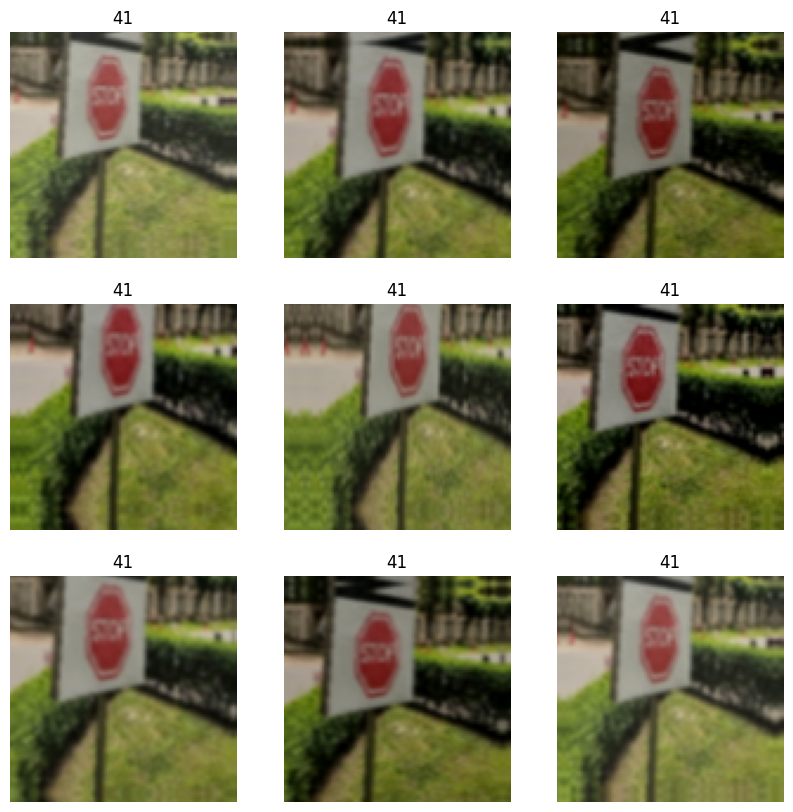

In [ ]:
import numpy as np

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
nb_classes = 48
inputs = keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

scale_layer = keras.layers.Rescaling(scale=1 / 255.0, offset=-1)
x = scale_layer(x)

x = layers.Conv2D(32,  kernel_size = (3,3),padding='valid', activation='relu')(x)
x = layers.Conv2D(32,  kernel_size = (3,3),padding='valid', activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(rate=0.25)(x)

x = layers.Conv2D(64, kernel_size = (3,3),padding='valid', activation='relu')(x)
x = layers.Conv2D(64,  kernel_size = (3,3),padding='valid', activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(rate=0.25)(x)


x = layers.Conv2D(128, kernel_size = (3,3),padding='valid', activation='relu')(x)
x = layers.Conv2D(256, kernel_size = (3,3),padding='valid', activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(rate=0.25)(x)



x = layers.Flatten()(x)


x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(rate=0.5)(x)
outputs = layers.Dense(nb_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 32)       0         
 )                                                               
                                                             

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-3),  loss='sparse_categorical_crossentropy',metrics =['accuracy'])

In [ ]:
epochs = 100
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

Epoch 1/100
600/600 [==============================] - 60s 76ms/step - loss: 3.0311 - accuracy: 0.2211 - val_loss: 1.2896 - val_accuracy: 0.6656
Epoch 2/100
600/600 [==============================] - 27s 44ms/step - loss: 1.6006 - accuracy: 0.5709 - val_loss: 0.6729 - val_accuracy: 0.8171
Epoch 3/100
600/600 [==============================] - 28s 46ms/step - loss: 1.1548 - accuracy: 0.6779 - val_loss: 0.5408 - val_accuracy: 0.8435
Epoch 4/100
600/600 [==============================] - 26s 43ms/step - loss: 0.9097 - accuracy: 0.7399 - val_loss: 0.3799 - val_accuracy: 0.8944
Epoch 5/100
600/600 [==============================] - 25s 42ms/step - loss: 0.7784 - accuracy: 0.7734 - val_loss: 0.3335 - val_accuracy: 0.9052
Epoch 6/100
600/600 [==============================] - 25s 42ms/step - loss: 0.6811 - accuracy: 0.8005 - val_loss: 0.2999 - val_accuracy: 0.9133
Epoch 7/100
600/600 [==============================] - 27s 44ms/step - loss: 0.5942 - accuracy: 0.8211 - val_loss: 0.2558 - val_ac

In [ ]:
scores = model.evaluate(test_dataset)

23/23 [==============================] - 1s 32ms/step - loss: 0.0259 - accuracy: 0.9944


In [ ]:
class_names = validation_dataset.class_names

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


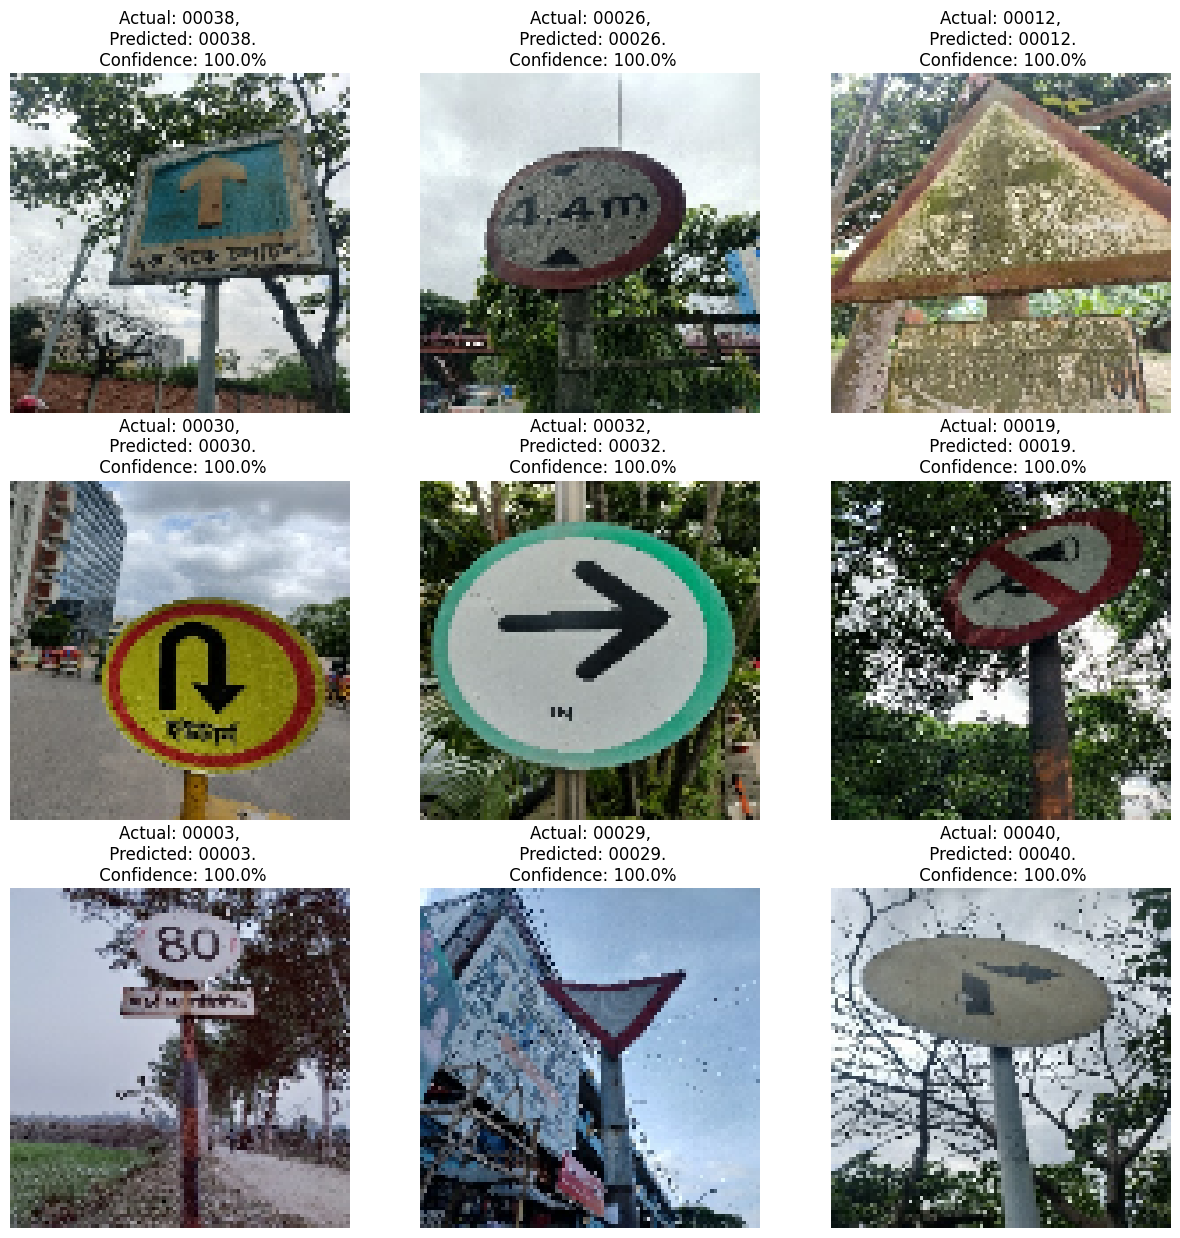

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 [==============================] - 0s 18ms/step


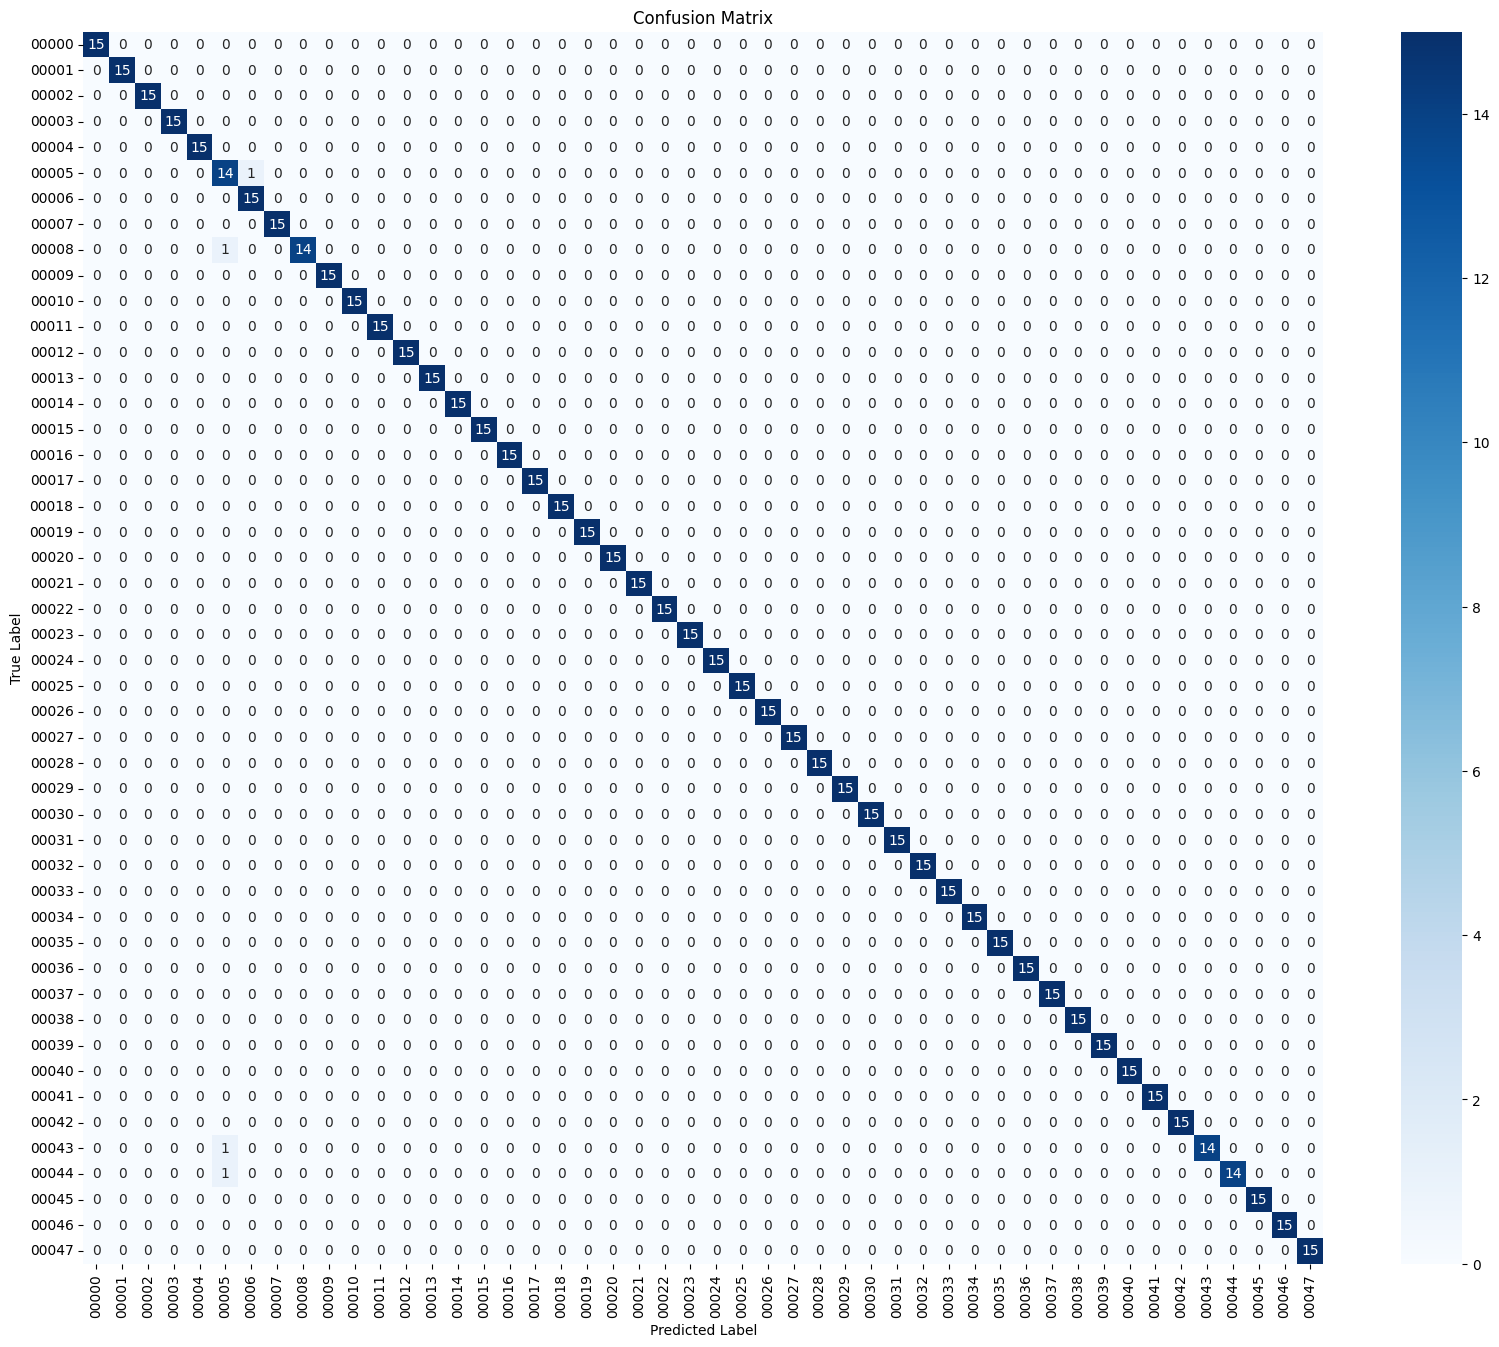

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace 'Class 0' and 'Class 1' with the actual class names from your dataset
class_names = test_dataset.class_names

# Create empty arrays to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to obtain true and predicted labels
for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap using seaborn
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

# Add a title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

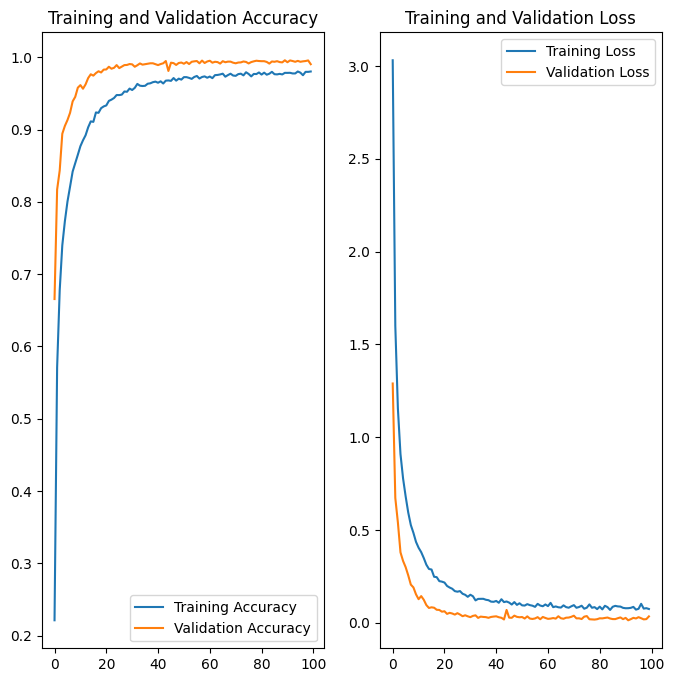

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 31ms/step


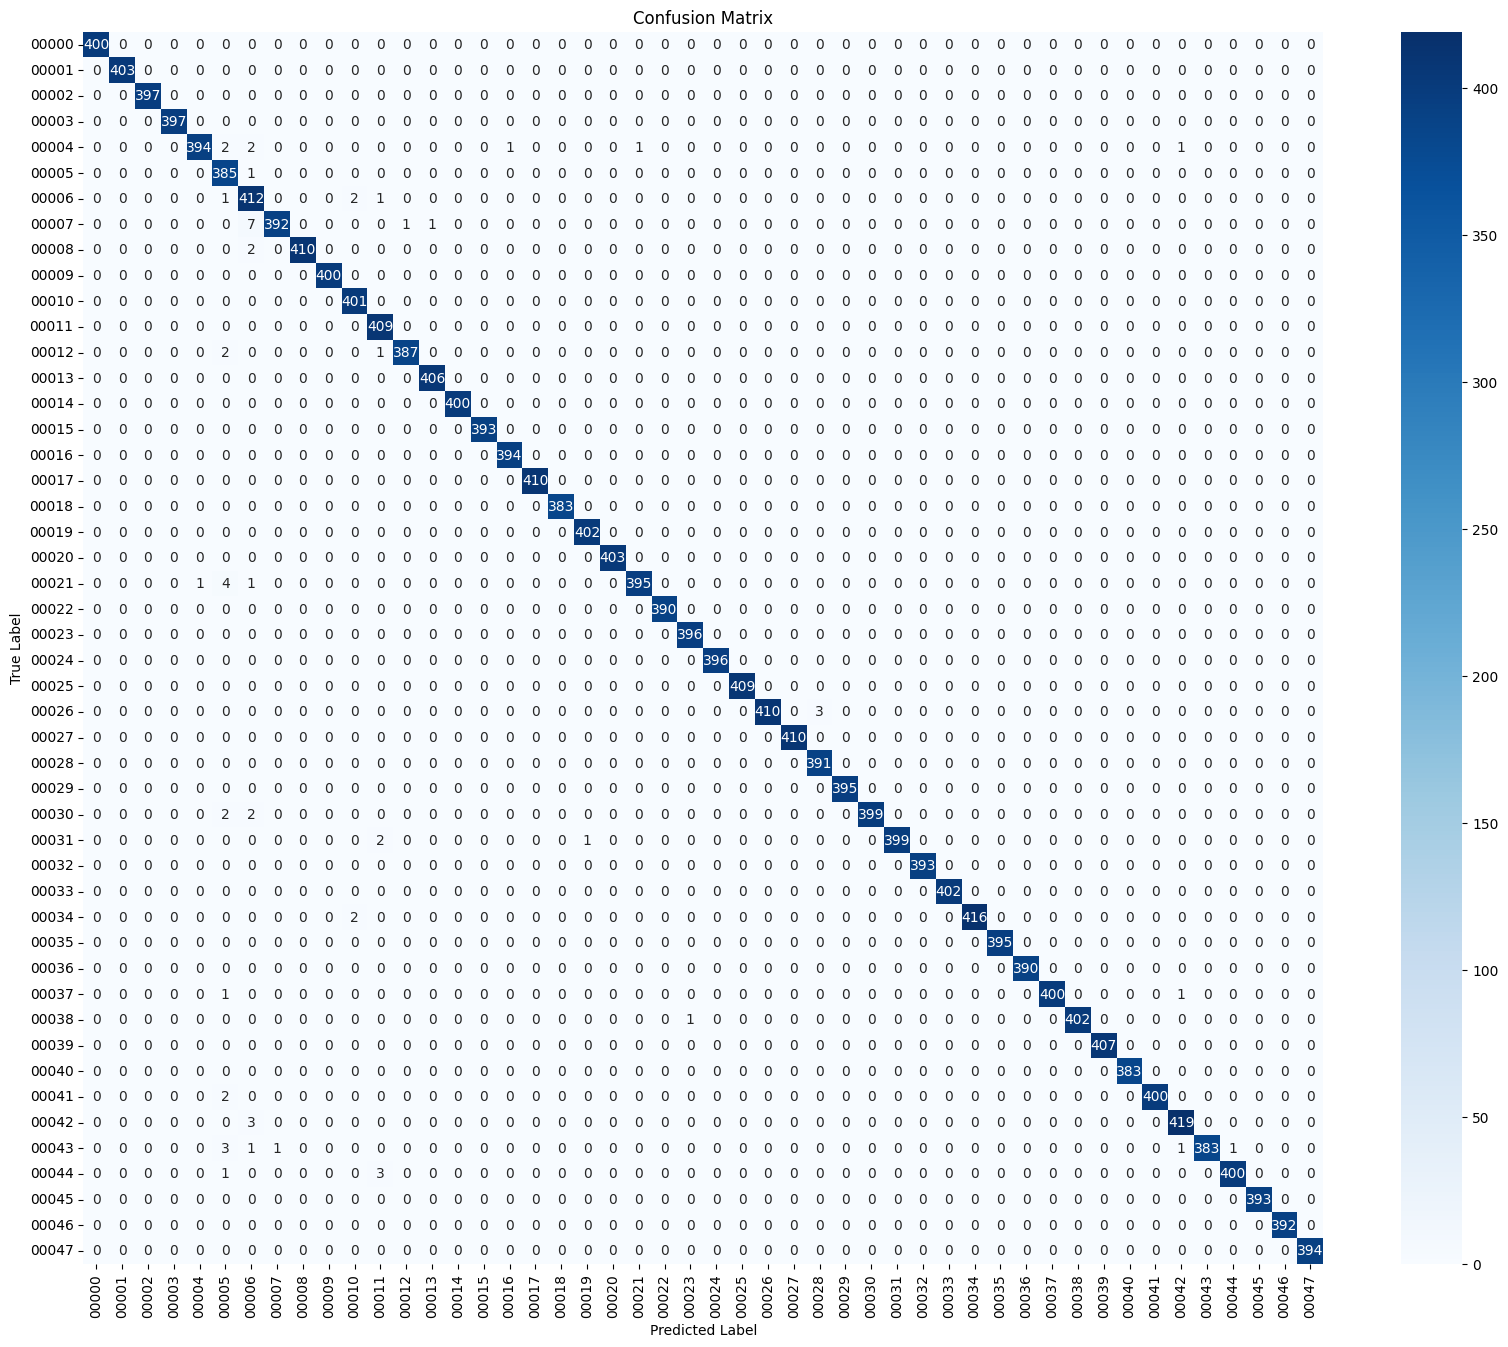

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace 'Class 0' and 'Class 1' with the actual class names from your dataset
class_names = train_dataset.class_names

# Create empty arrays to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to obtain true and predicted labels
for images, labels in train_dataset:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap using seaborn
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

# Add a title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

1/1 [==============================] - 0s 30ms/step


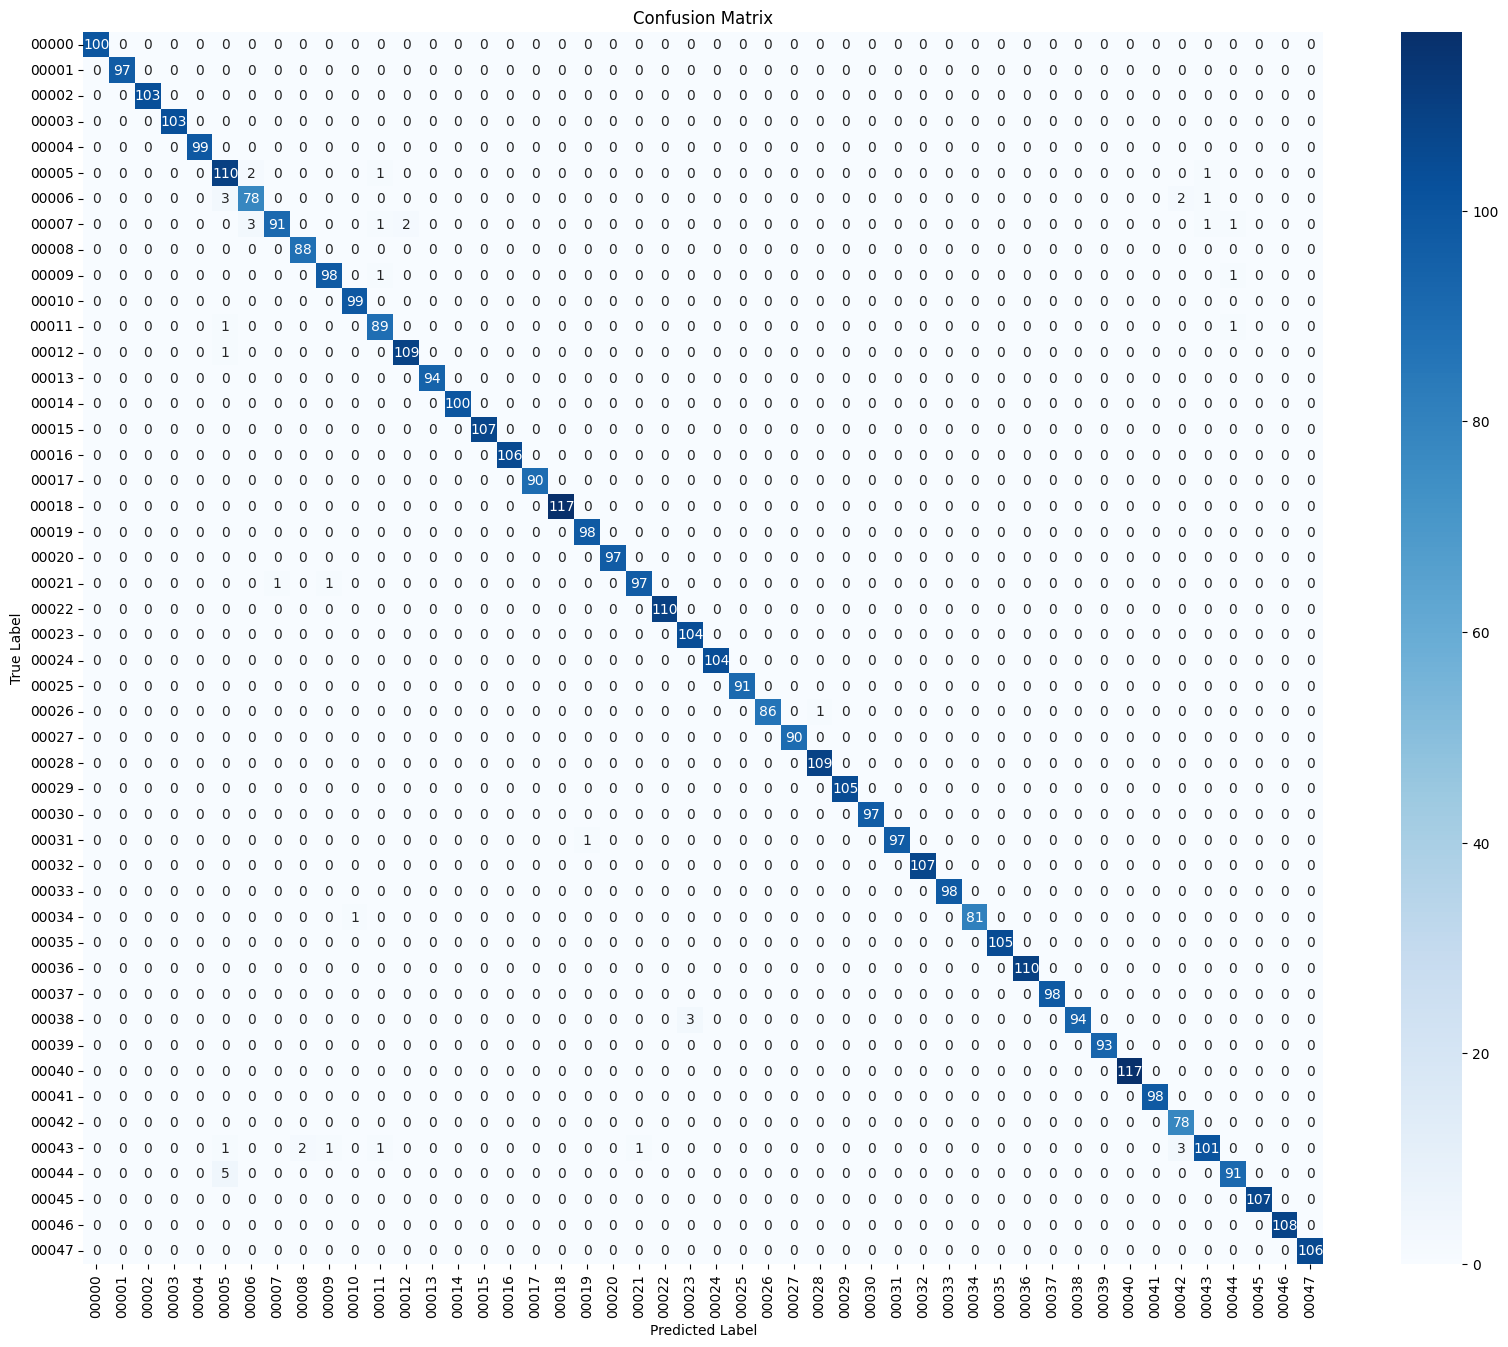

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace 'Class 0' and 'Class 1' with the actual class names from your dataset
class_names = validation_dataset.class_names

# Create empty arrays to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to obtain true and predicted labels
for images, labels in validation_dataset:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap using seaborn
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

# Add a title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

1/1 [==============================] - 0s 27ms/step
F1 Score: 0.9904096259944054
Precision: 0.9905477914951865
Recall: 0.9904725389694512
ROC-AUC Score: 0.9999701394573866


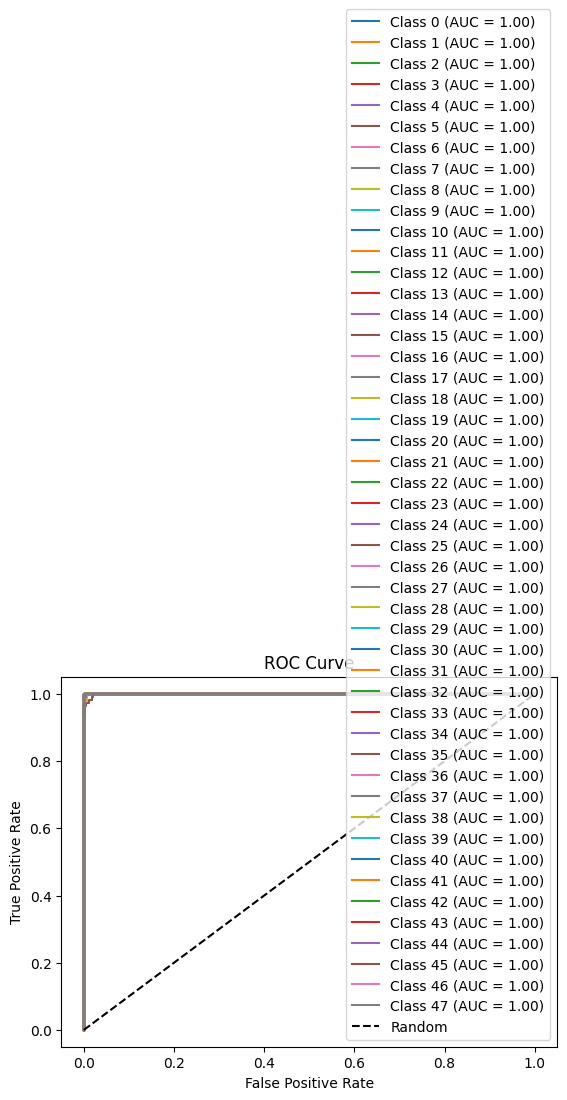

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


# After model.fit(...)
validation_dataset = validation_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

y_true = []
y_pred = []

for x_val, y_val in validation_dataset:
    y_true.append(y_val.numpy()[0])  # Append true labels
    y_pred.append(model.predict(x_val)[0])  # Append predicted probabilities (raw output)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the metrics
f1 = f1_score(y_true, y_pred_classes, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovo')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC curves (only for binary classification or when using one-hot encoded labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(nb_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


1/1 [==============================] - 0s 18ms/step
F1 Score: 0.9945686179087875
Precision: 0.9950214460784315
Recall: 0.9944444444444445
ROC-AUC Score: 0.999960598896769


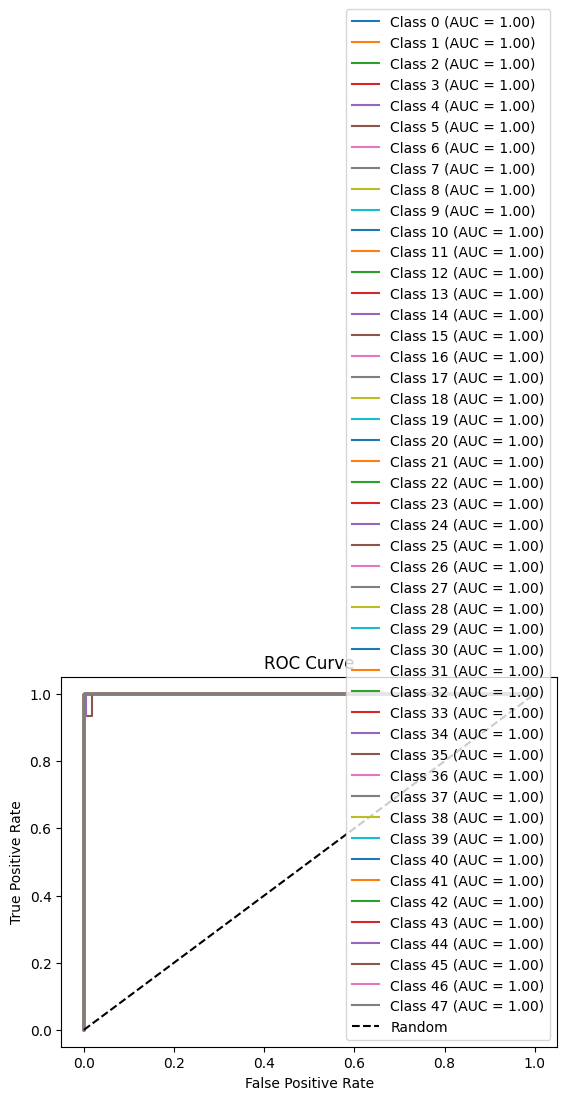

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


# After model.fit(...)
test_dataset = test_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

y_true = []
y_pred = []

for x_val, y_val in test_dataset:
    y_true.append(y_val.numpy()[0])  # Append true labels
    y_pred.append(model.predict(x_val)[0])  # Append predicted probabilities (raw output)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the metrics
f1 = f1_score(y_true, y_pred_classes, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovo')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC curves (only for binary classification or when using one-hot encoded labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(nb_classes):
   plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
